In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from PIL import Image
from tqdm import tqdm
import os
import random
import cv2

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.version.__version__

'1.12.0a0+8a1a93a'

In [3]:
torch.cuda.is_available()

True

In [2]:
root = "/workspace/Yude/OB file"
train_root_dir = 'train'
train_pairs_list = []

for fit_ in ['fit', 'nofit']:
    fit_dir = f"{root}/{train_root_dir}/{fit_}"
    for pair in os.listdir(fit_dir):
        imgs = os.listdir(f"{fit_dir}/{pair}")
        train_pairs_list.append([
                            f"{fit_dir}/{pair}/{imgs[0]}", 
                            f"{fit_dir}/{pair}/{imgs[1]}",
                            int(fit_ == 'fit')
                            ])
random.shuffle(train_pairs_list)
train_pairs_list

[['/workspace/Yude/OB file/train/fit/fit1353/BA5569.jpg',
  '/workspace/Yude/OB file/train/fit/fit1353/KG0942.jpg',
  1],
 ['/workspace/Yude/OB file/train/fit/fit486/BA5999.jpg',
  '/workspace/Yude/OB file/train/fit/fit486/EA3068.jpg',
  1],
 ['/workspace/Yude/OB file/train/nofit/nofit199/BA6112.jpg',
  '/workspace/Yude/OB file/train/nofit/nofit199/AB14888.jpg',
  0],
 ['/workspace/Yude/OB file/train/nofit/nofit1234/KG1110.jpg',
  '/workspace/Yude/OB file/train/nofit/nofit1234/AB15685.jpg',
  0],
 ['/workspace/Yude/OB file/train/nofit/nofit2032/KL0989.jpg',
  '/workspace/Yude/OB file/train/nofit/nofit2032/AB13684.jpg',
  0],
 ['/workspace/Yude/OB file/train/fit/fit1867/BA6013.jpg',
  '/workspace/Yude/OB file/train/fit/fit1867/KB1141.jpg',
  1],
 ['/workspace/Yude/OB file/train/nofit/nofit1903/CA2203.jpg',
  '/workspace/Yude/OB file/train/nofit/nofit1903/QA1179.jpg',
  0],
 ['/workspace/Yude/OB file/train/fit/fit851/AB11662.jpg',
  '/workspace/Yude/OB file/train/fit/fit851/EA2853.jpg',


In [3]:
def train_pairs_loader(train_data, batch_size):
    cnt = len(train_data) // batch_size + int(len(train_data) % batch_size != 0)
    for i in range(cnt):
        temp = i * (batch_size)
        yield train_data[temp : temp + batch_size]

In [4]:
root = "/workspace/Yude/OB file"
val_root_dir = 'test'
val_pairs_list = []

for fit_ in ['fit', 'nofit']:
    fit_dir = f"{root}/{val_root_dir}/{fit_}"
    for pair in os.listdir(fit_dir):
        imgs = os.listdir(f"{fit_dir}/{pair}")
        val_pairs_list.append([
                            f"{fit_dir}/{pair}/{imgs[0]}", 
                            f"{fit_dir}/{pair}/{imgs[1]}",
                            int(fit_ == 'fit')
                            ])
random.shuffle(val_pairs_list)
val_pairs_list

[['/workspace/Yude/OB file/test/fit/fit410/AB12259.jpg',
  '/workspace/Yude/OB file/test/fit/fit410/BA5510.jpg',
  1],
 ['/workspace/Yude/OB file/test/fit/fit364/KB1196.jpg',
  '/workspace/Yude/OB file/test/fit/fit364/BA6386.jpg',
  1],
 ['/workspace/Yude/OB file/test/fit/fit157/AB13608.jpg',
  '/workspace/Yude/OB file/test/fit/fit157/BA5948.jpg',
  1],
 ['/workspace/Yude/OB file/test/fit/fit535/AB13515.jpg',
  '/workspace/Yude/OB file/test/fit/fit535/BA5813.jpg',
  1],
 ['/workspace/Yude/OB file/test/fit/fit122/AB15701.jpg',
  '/workspace/Yude/OB file/test/fit/fit122/DA9292.jpg',
  1],
 ['/workspace/Yude/OB file/test/nofit/nofit405/AB14373.jpg',
  '/workspace/Yude/OB file/test/nofit/nofit405/CA2123.jpg',
  0],
 ['/workspace/Yude/OB file/test/nofit/nofit397/BA5981.jpg',
  '/workspace/Yude/OB file/test/nofit/nofit397/KS0783.jpg',
  0],
 ['/workspace/Yude/OB file/test/nofit/nofit530/KB1167.jpg',
  '/workspace/Yude/OB file/test/nofit/nofit530/AB13623.jpg',
  0],
 ['/workspace/Yude/OB file

In [5]:
def val_pairs_loader(val_data, batch_size):
    cnt = len(val_data) // batch_size + int(len(val_data) % batch_size != 0)
    for i in range(cnt):
        temp = i * (batch_size)
        yield val_data[temp : temp + batch_size]

In [6]:
#define embeddingnet which is used to extract image emabedding 
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        # ------------------------------------------------------------------------------
        # Remove the last layer (the classification layer) of VGG16 第一種寫法 把原本VGG的最後一層fc layer刪掉 直接線性輸出
        # self.backbone.classifier = nn.Sequential(*list(self.backbone.classifier.children())[:-1])
        # self.features = self.backbone.classifier
        # self.fc = nn.Linear(512, 1)
        # ------------------------------------------------------------------------------
        # 第二種寫法 
        
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(128, 10),#原num_classes 這裡要用多少維輸出來代表這個pic
            # nn.Softmax(dim=-1)#加了會梯度消失
        )
    def forward(self, x):
        #經過VGG提取特徵
        output = self.features(x)
        #flatten 不同模型 這裡的size不同
        output = output.view(output.size(0)*output.size(1)*output.size(2))
        #output = output.view((output.size(0), -1))
        # 經過fc層
        output = self.fc(output)
        return output
        
    # def get_embedding(self, x):
        # return self.forward(x)


In [7]:
print(EmbeddingNet())    

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EmbeddingNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [8]:
#define siamesenet which have 2 inputs
class SiameseNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(SiameseNet, self).__init__()
        self.EmbeddingNet = EmbeddingNet
        
    def forward(self, x1, x2):
        output1 = self.EmbeddingNet(x1)
        output2 = self.EmbeddingNet(x2)
        return output1, output2

In [95]:
# embedding_net = EmbeddingNet()
# siamese_net = SiameseNet(embedding_net)
# print(siamese_net)

In [9]:
#define contrastive loss
#loss function reference https://jdhao.github.io/2017/03/13/some_loss_and_explanations/
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.5): #margin要自己定義 2
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        #self.eps = 1e-9
    
    #這邊可以改成不同距離計算方式 這裡先用歐幾里德距離計算
    def forward(self, embedding1, embedding2, label):
        distance = F.pairwise_distance(embedding1, embedding2, p=2)
        #本來最前面是(1-label)
        loss = torch.mean(label * torch.pow(distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

In [10]:
embedding_net = EmbeddingNet()
siamese_net = SiameseNet(embedding_net)
# print(siamese_net)

#training 
learning_rate = 5e-6
epoch = 40
batch_size = 256
margin = torch.tensor(1.5)

if 4775%batch_size != 0:
    train_bar_len = int((4775/batch_size)+1)
else:
    train_bar_len = int(4775/batch_size)

if 1210%batch_size != 0:
    val_bar_len = int((1210/batch_size)+1)
else:
    val_bar_len = int(1210/batch_size)
    
if torch.cuda.is_available():
    siamese_net.cuda()
    
params = [{'params': md.parameters()} for md in siamese_net.children()
        if md in [siamese_net.EmbeddingNet.fc]]
optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
loss_func = ContrastiveLoss()

train_dataloader = train_pairs_loader(train_pairs_list, batch_size)
siamese_net.train()

transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])
#紀錄每個epoch的acc跟loss
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for i in range(epoch):
    print(f'epoch {i+1}')
    pbar=tqdm(total=train_bar_len)
    train_loss = 0.
    train_acc = 0.
    for batch_ in train_pairs_loader(train_pairs_list, batch_size):
        for img1_p, img2_p, label_ in batch_ :
            img1 = Image.open(img1_p)
            img2 = Image.open(img2_p)
            img1_t = transform(img1)
            img2_t = transform(img2)
            x1 = Variable(img1_t).cuda()
            x2 = Variable(img2_t).cuda()
            label_ = torch.tensor(label_)#默認int64 float32
            label = Variable(label_).cuda()
            optimizer.zero_grad()
            embedding1, embedding2 = siamese_net(x1, x2)
            loss = loss_func(embedding1, embedding2, label)
            train_loss += loss.item()
            #距離大於或等於margin是不搭 小於margin是搭
            train_distance = F.pairwise_distance(embedding1, embedding2, p=2)
            if train_distance >= margin:
                train_pred = 0
            else:
                train_pred = 1
                
            if train_pred == label_:
                train_acc += 1
            
            loss.backward()
            optimizer.step()
        pbar.update(1)
    pbar.close()

    loss_value = train_loss / (len(train_pairs_list))
    acc_value = train_acc / (len(train_pairs_list))
    train_acc_list.append(100*acc_value)
    train_loss_list.append(loss_value)
    print('Train Loss: {:.6f}, Train Acc: {:.6f}'.format(loss_value, acc_value))
    #-------------------------------------------------------------------------------------------------------------------------------------------------------
    #evalution
    siamese_net.eval()
    val_loss = 0.
    val_acc = 0.
    pbar=tqdm(total=val_bar_len)
    y_true = []
    y_pred = []
    #還要加tqdm的bar要多長
    for batch_ in val_pairs_loader(val_pairs_list, batch_size):
        for img1_p, img2_p, label_ in batch_ :
            img1 = Image.open(img1_p)
            img2 = Image.open(img2_p)
            img1_t = transform(img1)
            img2_t = transform(img2)
            x1 = Variable(img1_t).cuda()
            x2 = Variable(img2_t).cuda()
            label_ = torch.tensor(label_)
            label = Variable(label_).cuda()
            embedding1, embedding2 = siamese_net(x1, x2)
            loss = loss_func(embedding1, embedding2, label)
            val_loss += loss.item()
            #距離大於或等於margin是不搭 小於margin是搭
            val_distance = F.pairwise_distance(embedding1, embedding2, p=2)
            if val_distance >= margin:
                val_pred = 0
            else:
                val_pred = 1
                
            if val_pred == label_:
                val_acc += 1
            #混淆矩陣要用的
            y_true.append(label_)
            y_pred.append(val_pred)
        pbar.update(1)
    pbar.close()
    
    acc_value = val_acc / (len(val_pairs_list))
    loss_value = val_loss / (len(val_pairs_list))
    val_acc_list.append(100*acc_value)
    val_loss_list.append(loss_value)
    print('val Loss: {:.6f}, Val Acc: {:.6f}'.format(loss_value,acc_value))
    


epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.67s/it]


Train Loss: 0.502309, Train Acc: 0.530681


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


val Loss: 0.417078, Val Acc: 0.517355
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.61s/it]


Train Loss: 0.274364, Train Acc: 0.635393


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


val Loss: 0.293229, Val Acc: 0.654545
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.62s/it]


Train Loss: 0.163958, Train Acc: 0.721885


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


val Loss: 0.291438, Val Acc: 0.682645
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.54s/it]


Train Loss: 0.099012, Train Acc: 0.782827


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


val Loss: 0.310041, Val Acc: 0.710744
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:43<00:00,  5.47s/it]


Train Loss: 0.058955, Train Acc: 0.826387


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


val Loss: 0.337134, Val Acc: 0.727273
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.58s/it]


Train Loss: 0.047307, Train Acc: 0.840628


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


val Loss: 0.346082, Val Acc: 0.752893
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:43<00:00,  5.43s/it]


Train Loss: 0.046161, Train Acc: 0.832670


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


val Loss: 0.323337, Val Acc: 0.746281
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.55s/it]


Train Loss: 0.037782, Train Acc: 0.852775


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


val Loss: 0.332616, Val Acc: 0.766942
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:43<00:00,  5.47s/it]


Train Loss: 0.030960, Train Acc: 0.864712


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


val Loss: 0.322519, Val Acc: 0.742149
epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.60s/it]


Train Loss: 0.028407, Train Acc: 0.871623


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


val Loss: 0.335556, Val Acc: 0.768595
epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.57s/it]


Train Loss: 0.023203, Train Acc: 0.885864


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


val Loss: 0.313955, Val Acc: 0.760331
epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.52s/it]


Train Loss: 0.024314, Train Acc: 0.889843


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


val Loss: 0.310054, Val Acc: 0.768595
epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.54s/it]


Train Loss: 0.021940, Train Acc: 0.892356


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


val Loss: 0.314129, Val Acc: 0.755372
epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.55s/it]


Train Loss: 0.020244, Train Acc: 0.896545


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


val Loss: 0.329119, Val Acc: 0.790909
epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.65s/it]


Train Loss: 0.018785, Train Acc: 0.909738


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


val Loss: 0.306113, Val Acc: 0.752066
epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.54s/it]


Train Loss: 0.017482, Train Acc: 0.907016


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]


val Loss: 0.331970, Val Acc: 0.791736
epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.60s/it]


Train Loss: 0.017821, Train Acc: 0.916649


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


val Loss: 0.321708, Val Acc: 0.764463
epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.61s/it]


Train Loss: 0.017177, Train Acc: 0.915183


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


val Loss: 0.311972, Val Acc: 0.766942
epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.64s/it]


Train Loss: 0.015059, Train Acc: 0.925445


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.330429, Val Acc: 0.794215
epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.57s/it]


Train Loss: 0.015533, Train Acc: 0.920838


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


val Loss: 0.328501, Val Acc: 0.767769
epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.50s/it]


Train Loss: 0.013855, Train Acc: 0.928377


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.307141, Val Acc: 0.765289
epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.50s/it]


Train Loss: 0.014386, Train Acc: 0.927958


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.354977, Val Acc: 0.789256
epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:43<00:00,  5.42s/it]


Train Loss: 0.013552, Train Acc: 0.933403


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


val Loss: 0.337095, Val Acc: 0.792562
epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.66s/it]


Train Loss: 0.013294, Train Acc: 0.930262


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


val Loss: 0.327177, Val Acc: 0.781818
epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.64s/it]


Train Loss: 0.013783, Train Acc: 0.932984


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


val Loss: 0.332907, Val Acc: 0.794215
epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.57s/it]


Train Loss: 0.014225, Train Acc: 0.935916


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


val Loss: 0.333328, Val Acc: 0.790909
epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.58s/it]


Train Loss: 0.011697, Train Acc: 0.941780


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


val Loss: 0.332491, Val Acc: 0.767769
epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:48<00:00,  5.72s/it]


Train Loss: 0.012959, Train Acc: 0.937801


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.326021, Val Acc: 0.775207
epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.56s/it]


Train Loss: 0.012456, Train Acc: 0.936545


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]


val Loss: 0.326661, Val Acc: 0.771074
epoch 30


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.53s/it]


Train Loss: 0.010783, Train Acc: 0.944084


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


val Loss: 0.321127, Val Acc: 0.784298
epoch 31


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:47<00:00,  5.66s/it]


Train Loss: 0.011567, Train Acc: 0.941990


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.326014, Val Acc: 0.780992
epoch 32


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.52s/it]


Train Loss: 0.012340, Train Acc: 0.944712


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


val Loss: 0.330798, Val Acc: 0.785124
epoch 33


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.62s/it]


Train Loss: 0.011767, Train Acc: 0.944712


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.322943, Val Acc: 0.769421
epoch 34


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.58s/it]


Train Loss: 0.009624, Train Acc: 0.948482


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


val Loss: 0.333184, Val Acc: 0.792562
epoch 35


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.57s/it]


Train Loss: 0.010999, Train Acc: 0.947435


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


val Loss: 0.353843, Val Acc: 0.800000
epoch 36


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.49s/it]


Train Loss: 0.012184, Train Acc: 0.941361


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


val Loss: 0.341015, Val Acc: 0.799174
epoch 37


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:46<00:00,  5.60s/it]


Train Loss: 0.009182, Train Acc: 0.954555


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


val Loss: 0.350190, Val Acc: 0.779339
epoch 38


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:45<00:00,  5.53s/it]


Train Loss: 0.010658, Train Acc: 0.945340


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


val Loss: 0.309395, Val Acc: 0.759504
epoch 39


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.49s/it]


Train Loss: 0.010577, Train Acc: 0.948691


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


val Loss: 0.353463, Val Acc: 0.789256
epoch 40


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:44<00:00,  5.49s/it]


Train Loss: 0.010127, Train Acc: 0.953298


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]

val Loss: 0.328945, Val Acc: 0.781818


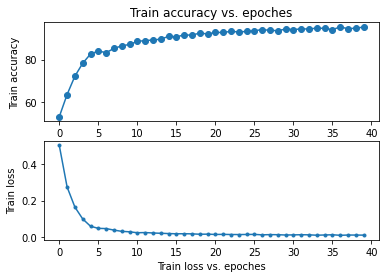

In [11]:
import matplotlib.pyplot as plt

x1 = range(0, epoch)
x2 = range(0, epoch)
y1 = train_acc_list
y2 = train_loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


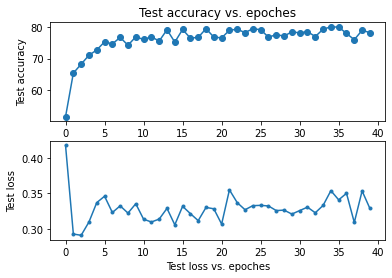

In [12]:
x1 = range(0, epoch)
x2 = range(0, epoch)
y1 = val_acc_list
y2 = val_loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()

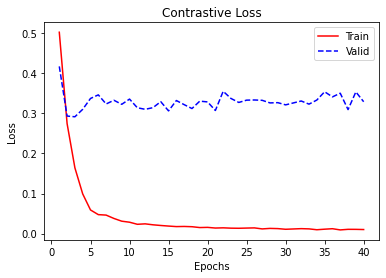

In [13]:
epochs =[i+1 for i in range(epoch)]
plt.plot(epochs,train_loss_list, color='red', label='Train')
plt.plot(epochs,val_loss_list, '--', color='blue', label='Valid')
plt.title('Contrastive Loss') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
plt.show()

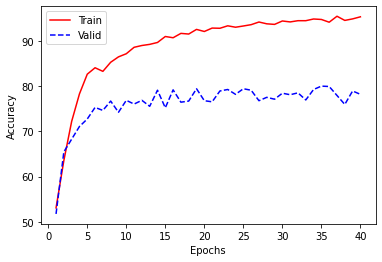

In [14]:
epochs =[i+1 for i in range(epoch)]
plt.plot(epochs,train_acc_list, color='red', label='Train')
plt.plot(epochs,val_acc_list, '--', color='blue', label='Valid')
plt.ylabel("Accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
plt.show()

In [15]:
a=0
for idx, i in enumerate(y_true):
    if i == 0 and 1 == y_pred[idx]:
        a+=1
a
#fp

230

In [16]:
a=0
for idx, i in enumerate(y_true):
    if i == 0 and 0 == y_pred[idx]:
        a+=1
a
#tn

380

In [17]:
a=0
for idx, i in enumerate(y_true):
    if i == 1 and 1 == y_pred[idx]:
        a+=1
a
#tp

566

In [18]:
a=0
for idx, i in enumerate(y_true):
    if i == 1 and 0 == y_pred[idx]:
        a+=1
a
#fn

34

In [20]:
from sklearn.metrics import confusion_matrix
#官方定義0是positive 1是negative
         #pred
        #   0  1
 #actual#0 tp fn
        #1 fp tn
cm = confusion_matrix(y_true, y_pred)

#我們0是不搭 1是搭
#   0  1
#0 tn fp
#1 fn tp
tn=cm[0][0]
fp=cm[0][1]
fn=cm[1][0]
tp=cm[1][1]
print("Accuracy:",(tp+tn)/(tp+fn+fp+tn) )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.7818181818181819
FIT precision: 0.7110552763819096
FIT recall: 0.9433333333333334
n_FIT precision: 0.9178743961352657
n_FIT recall: 0.6229508196721312
F1 0.8108882521489971


[0.         0.37704918 1.        ] [0.         0.94333333 1.        ] [2 1 0]


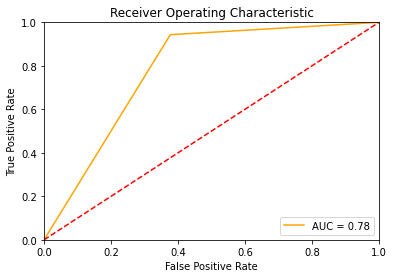

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [22]:
# siamese_net.eval()
# img_embedding_list = []
# for img1_p, img2_p, label_ in tqdm(val_pairs_list, total=len(val_pairs_list)) :
#             img1 = Image.open(img1_p)
#             img2 = Image.open(img2_p)
#             img1_t = transform(img1)
#             img2_t = transform(img2)
#             x1 = Variable(img1_t).cuda()
#             x2 = Variable(img2_t).cuda()
#             embedding1, embedding2 = siamese_net(x1, x2)
#             break
#             #img_embedding_list.extend([[img1_p,embedding1],[img2_p,embedding2],label_])
    

In [23]:
#保存想要的模型參數
#torch.save(siamese_net.state_dict(), ".pt")

In [ ]:
#載入之前保存的模型參數
# embedding_net = EmbeddingNet()
# siamese_net = SiameseNet(embedding_net)

# siamese_net.load_state_dict(torch.load(".pt"))
# siamese_net.to("cuda")